## Transfer Learning With Tensorflow

What is Transfer Learning?

-surely someone has spent the time crafting the right model for job...

Examples of Transfer Learning
* IMAGENET------>food Vision
* NLP---------->some other use case

Why we use Transfer Learning?

* Can Leverage an existing neural Network architecture proven to work on problems similar to our own
* Can Leverage a Working Network architecture which has already learned parameters on similar data to our own(often results in a great results with less data)

In [1]:
#Are we using GPU?
!nvidia-smi

Mon Mar 13 13:16:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0    25W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Downloading and Becoming one with the Data

In [2]:
#Get  data(10% of 10 food classes from Food101)

import zipfile
import wget

#download the data
url="https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
filename=wget.download(url)
print(filename)

100% [......................................................................] 168546183 / 16854618310_food_classes_10_percent.zip


In [4]:
#Unzip the zip file

zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [2]:
#How many images in each folder?
import os

#Walk through 10% data directory and list number of files
for dirpath,datadir,filenames in os.walk("10_food_classes_10_percent/"):
    print(f"There are {len(datadir)} directories and {len(filenames)} in {dirpath}")

There are 2 directories and 0 in 10_food_classes_10_percent/
There are 10 directories and 0 in 10_food_classes_10_percent/test
There are 0 directories and 250 in 10_food_classes_10_percent/test\chicken_curry
There are 0 directories and 250 in 10_food_classes_10_percent/test\chicken_wings
There are 0 directories and 250 in 10_food_classes_10_percent/test\fried_rice
There are 0 directories and 250 in 10_food_classes_10_percent/test\grilled_salmon
There are 0 directories and 250 in 10_food_classes_10_percent/test\hamburger
There are 0 directories and 250 in 10_food_classes_10_percent/test\ice_cream
There are 0 directories and 250 in 10_food_classes_10_percent/test\pizza
There are 0 directories and 250 in 10_food_classes_10_percent/test\ramen
There are 0 directories and 250 in 10_food_classes_10_percent/test\steak
There are 0 directories and 250 in 10_food_classes_10_percent/test\sushi
There are 10 directories and 0 in 10_food_classes_10_percent/train
There are 0 directories and 75 in 10_f

### Creating Data Loader(preparing the data)

We'll use `ImageDataGenerator` class to load in our images in batches

In [20]:
#setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print('Training Images')
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                            target_size=IMAGE_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical")

print('Testing Images')
test_data=test_datagen.flow_from_directory(test_dir,
                                          target_size=IMAGE_SHAPE,
                                          batch_size=BATCH_SIZE,
                                          class_mode="categorical")

Training Images
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


### Introducing callbacks in tensorflow and making a callbacks to track our model

#setting up callbacks(things to run whilst our model)


Callbacks are extra functionality you can add to our models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with the Tensorboard callback
* Model Checkpoint with the ModelCheckpoint callback
* Stoping a model from training (before it train too long and overfit)  with the EarlyStopping callback


only mentioned 3 there is a lot

In [22]:
#Create Tensorboard callback (funtionalized because  we need to create new one for each model)

import datetime

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback
    

**Note:** you can customize the directory where your Tensorboard logs(model Training metrics) get saved to whatever you like.
The `log_dir` parameter we have created  above is only one option

### Creating model using Tensorflow Hub

In the past we've used Tensorflow to create our own models layer by layer from scratch

Now we are going to do similar process, except the majority of our model's layer are going to come from Tensorflow Hub.

We can access pretrained models on https://tfhub.dev/


Browsing the Tensorflow Hub page and sorting for image classification, we  found the following feature vector model link https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [5]:
#Let's compare the following two models

resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
#!pip install tensorflow_hub


In [10]:
#Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [13]:
#Let's make a create_model() function to create a model from url

def create_model(model_url,num_classes=10):
    """
    Takes a tensorflow HUB url and creates a keras Sequential model with it.
    
    Args:
       model_url (str) : A Tensorflow Hub feature extraction url
       num_classes (int) : Number of output neurons in the output layer, should be
                        equal to number of Target classes, default 10.
                        
    Returns:
       An uncompiled Keras Sequential  model with model url as feature extracter layer and 
       Dense output layer with num_classes output neurons.
       
    """
    
    #Download the pretrained Model and saved it as a keras layer
    feature_extractor_layer=hub.KerasLayer(model_url,
                                          trainable=False,  #Freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)
                                          )
    
    
    #Create our own model
    model=tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(10,activation="softmax",name="output_layer")
    ])
    
    return model

### Creating and Testing ResNet TensorFlow hub Feature Extraction model

In [17]:
#Create Resnet model

resnet_model=create_model(model_url=resnet_url,
                         num_classes=train_data_10_percent.num_classes)

In [18]:
#Let's see model summary
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [19]:
#Compile our Resnet model
resnet_model.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [23]:
#Let's fit our Resnet model to the data(10 percent data)
resnet_history=resnet_model.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=len(test_data),
                               callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                     experiment_name="resnet50V2")])



Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230313-162342
Epoch 1/5
24/24 [==============================] - 36s 978ms/step - loss: 1.8397 - accuracy: 0.3920 - val_loss: 1.1711 - val_accuracy: 0.6344
Epoch 2/5
24/24 [==============================] - 8s 355ms/step - loss: 0.8731 - accuracy: 0.7467 - val_loss: 0.8424 - val_accuracy: 0.7376
Epoch 3/5
24/24 [==============================] - 8s 358ms/step - loss: 0.5927 - accuracy: 0.8387 - val_loss: 0.7409 - val_accuracy: 0.7668
Epoch 4/5
24/24 [==============================] - 8s 359ms/step - loss: 0.4619 - accuracy: 0.8773 - val_loss: 0.6902 - val_accuracy: 0.7836
Epoch 5/5
24/24 [==============================] - 248s 11s/step - loss: 0.3696 - accuracy: 0.9200 - val_loss: 0.6747 - val_accuracy: 0.7868


Wow!  

That is Incredible. our transfer Learning Feature extractor model out performed all of the previous models we built by hand...(substantially)
and in quicker training time and with only 10% of the training examples

In [28]:
#Let's create the fuction to plot our loss curves...

#Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...


import matplotlib.pyplot as plt

#plot the validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for Trainig and validation metrics
    
    Args:
      history: Tensorflow history object
      
    Returns:
       Plots of training/validation loss and accuracy metrics.
    """
    loss=history.history["loss"]
    val_loss=history.history["val_loss"]
    
    accuracy=history.history["accuracy"]
    val_accuracy=history.history["val_accuracy"]
    
    epochs=range(len(history.history["loss"]))
    
    
    #plot loss
    plt.plot(epochs,loss,label="training_loss")
    plt.plot(epochs,val_loss,label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    
    #plot accuracy
    plt.figure()
    plt.plot(epochs,accuracy,label="training_accuracy")
    plt.plot(epochs,val_accuracy,label='Val_accuracy')
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

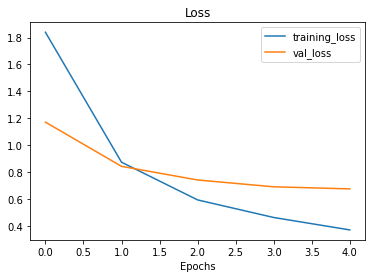

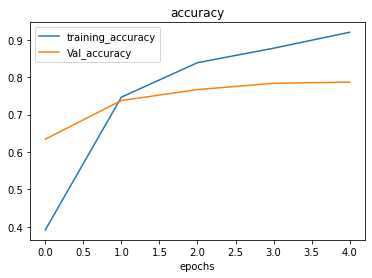

In [29]:
plot_loss_curves(resnet_history)

details on efficient net https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

In [30]:
#Create EfficientNetB0 feature extractor model  https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model=create_model(model_url=efficientnet_url,
                               num_classes=train_data_10_percent)


#Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

#Fit the model
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                                           epochs=5,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data,
                                           validation_steps=len(test_data),
                                           callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                experiment_name="efficientnetbO)" )])

Saving TensorBoard log files to: tensorflow_hub/efficientnetbO)/20230313-170328
Epoch 1/5
24/24 [==============================] - 85s 3s/step - loss: 1.9037 - accuracy: 0.4040 - val_loss: 1.2987 - val_accuracy: 0.7324
Epoch 2/5
24/24 [==============================] - 78s 3s/step - loss: 1.0787 - accuracy: 0.7787 - val_loss: 0.8647 - val_accuracy: 0.8284
Epoch 3/5
24/24 [==============================] - 78s 3s/step - loss: 0.7666 - accuracy: 0.8400 - val_loss: 0.6910 - val_accuracy: 0.8484
Epoch 4/5
24/24 [==============================] - 78s 3s/step - loss: 0.6133 - accuracy: 0.8800 - val_loss: 0.6033 - val_accuracy: 0.8612
Epoch 5/5
24/24 [==============================] - 78s 3s/step - loss: 0.5172 - accuracy: 0.8987 - val_loss: 0.5501 - val_accuracy: 0.8664


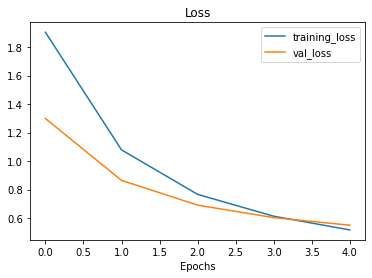

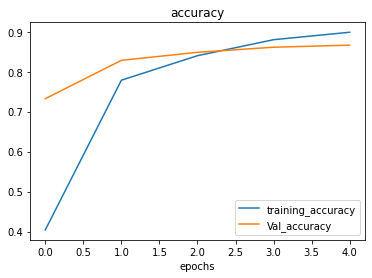

In [31]:
plot_loss_curves(efficientnet_history)

In [32]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [34]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [37]:
#how many layers are there in effiecientnetB0 feature extracter have?
efficientnet_model.layers

len(efficientnet_model.layers[0].weights)

309

#Different types of Transfer Learning

* **"As is"  transfer learning**- using an existing model with no changes what so ever(e.g using ImageNet model on 1000 imageNet classes, none of your own)
* **"feature extraction"**  transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on imagenet) and adjust the output layer for your own problem(e.g. 1000 classes --> 10 classes of food)

* **"fine-tuning  transfer learning**-use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers( including new output layers)

### Comparing our model results using TesorBoard

What is TensorBoard?


* A way to visually explore your machine learning models performance and internals
* Host,track and share your machine learning experiments on TensorBoard.Dev

**Note:** When you upload things to TensorBoard.dev, your experiments are public. so if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [43]:
import tensorboard